In [1]:
import xarray as xr         # For handling NetCDF data
import numpy as np          # For array operations
import geopandas as gpd     # For geospatial dataframes and file I/O
from shapely.geometry import Point  # For creating point geometries
import xwrf
from shapely.geometry import shape
from shapely.ops import unary_union
import rasterio.features
from rasterio.transform import from_origin
import glob, os
import matplotlib.pyplot as plt

# Visualize sensitivity of frc_urb2d threshold

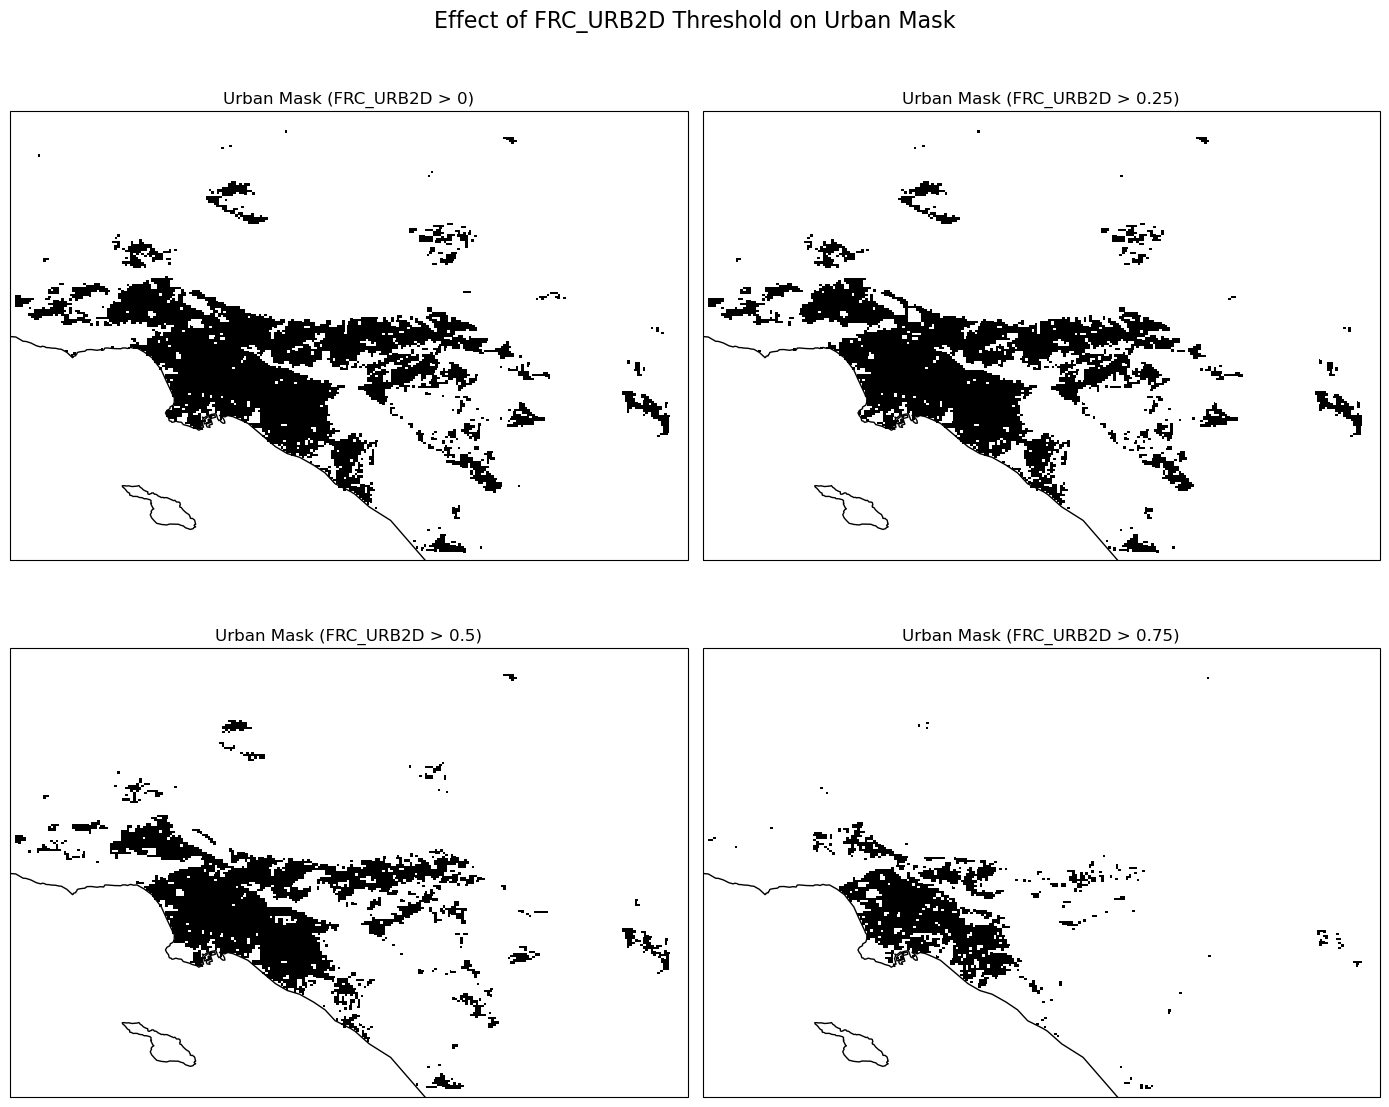

In [7]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# --- Load sample file ---
wrfout_sample = '/project2/zhan248_1326/hhao4018/WRFv4.6.1_Modified_AHoption_noChem/test/JOE_Default_2016_08_ah=0_v2/wrfout_d02_2016-08-12_20:00:00'
ds_temp = xr.open_dataset(wrfout_sample).xwrf.postprocess()

# --- CRS setup ---
wrf_crs = ds_temp.wrf_projection.item()
ds_temp = ds_temp.rio.write_crs(wrf_crs)

# --- Extract variables ---
frc_urb2d = ds_temp['FRC_URB2D'][0]

# Try to get 2D lat/lon
if 'south_north' in frc_urb2d.dims and 'west_east' in frc_urb2d.dims:
    lat = ds_temp['XLAT'][0].values if 'XLAT' in ds_temp else ds_temp['lat'].values
    lon = ds_temp['XLONG'][0].values if 'XLONG' in ds_temp else ds_temp['lon'].values
else:
    # if they are 1D, reshape
    lat = ds_temp['XLAT'].values
    lon = ds_temp['XLONG'].values
    ny, nx = frc_urb2d.shape
    lat = lat.reshape(ny, nx)
    lon = lon.reshape(ny, nx)

# --- Ensure shapes match ---
ny, nx = frc_urb2d.shape
lat = lat[:ny, :nx]
lon = lon[:ny, :nx]

# --- Define thresholds ---
thresholds = [0, 0.25, 0.5, 0.75]

# --- Plot ---
crs = ccrs.PlateCarree()
fig, axes = plt.subplots(2, 2, figsize=(14, 12), subplot_kw={'projection': crs})
axes = axes.ravel()

for i, thr in enumerate(thresholds):
    mask = (frc_urb2d > thr)
    pcm = axes[i].pcolormesh(lon, lat, mask, cmap='Greys', shading='auto', transform=crs)
    axes[i].coastlines()
    axes[i].set_title(f"Urban Mask (FRC_URB2D > {thr})")

fig.suptitle("Effect of FRC_URB2D Threshold on Urban Mask", fontsize=16)
plt.tight_layout()
plt.show()

# Based on set FRC_URB2D threshold

In [8]:
# get WRF urban mask
frc_urb2d_threshold = 0.5
wrfout_sample = '/project2/zhan248_1326/hhao4018/WRFv4.6.1_Modified_AHoption_noChem/test/JOE_Default_2016_08_ah=0_v2/wrfout_d02_2016-08-12_20:00:00'
ds_temp = xr.open_dataset(wrfout_sample).xwrf.postprocess()
wrf_crs = ds_temp.wrf_projection.item()
ds_temp = ds_temp.rio.write_crs(wrf_crs)
frc_urb2d = ds_temp['FRC_URB2D'][0]
wrf_urban_mask = (frc_urb2d > frc_urb2d_threshold)
# load LA County boundary
la_county_filepath='/home1/kojoseph/anthropogenic-heat-la-20230205/data/boundaries/la_county_bound_simplified_3.geojson'
la_county_boundary = gpd.read_file(la_county_filepath)

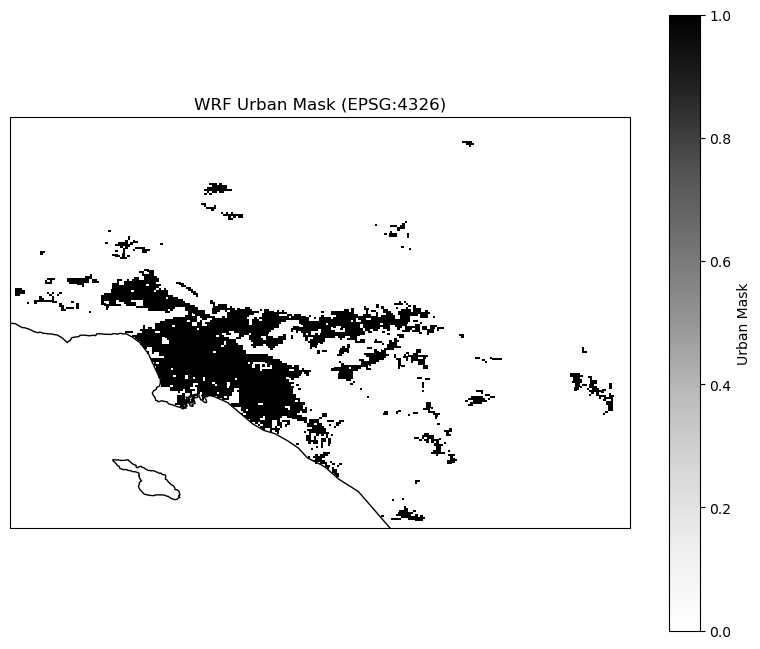

In [9]:
import cartopy.crs as ccrs
# EPSG:4326 is PlateCarree in Cartopy
crs = ccrs.PlateCarree()

mask = wrf_urban_mask.values
lat = wrf_urban_mask['XLAT'].values
lon = wrf_urban_mask['XLONG'].values

fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': crs})
pcm = ax.pcolormesh(lon, lat, mask, cmap='Greys', shading='auto', transform=crs)
ax.coastlines()
ax.set_title("WRF Urban Mask (EPSG:4326)")
plt.colorbar(pcm, ax=ax, label='Urban Mask')
plt.show()

In [ ]:
# get WRF urban mask
wrfout_sample = '/project2/zhan248_1326/hhao4018/WRFv4.6.1_Modified_AHoption_noChem/test/JOE_Default_2016_08_ah=0_v2/wrfout_d02_2016-08-12_20:00:00'
ds_temp = xr.open_dataset(wrfout_sample).xwrf.postprocess()
frc_urb2d = ds_temp['FRC_URB2D'][0]
wrf_urban_mask = (frc_urb2d > 0)

# save as geopackage
# Get lat/lon coordinates
lat = ds_temp['XLAT']
lon = ds_temp['XLONG']

# Flatten arrays and filter for urban cells
urban_lats = lat.values[wrf_urban_mask.values]
urban_lons = lon.values[wrf_urban_mask.values]

# Create GeoDataFrame of urban points
gdf = gpd.GeoDataFrame(
    geometry=[Point(lon, lat) for lon, lat in zip(urban_lons, urban_lats)],
    crs="EPSG:4326"
)



<AxesSubplot: >

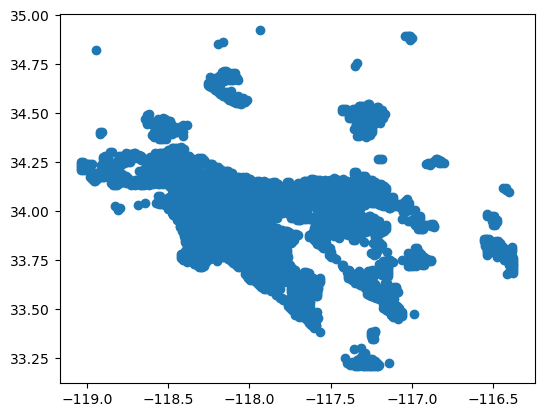

In [17]:
gdf.plot()

<AxesSubplot: >

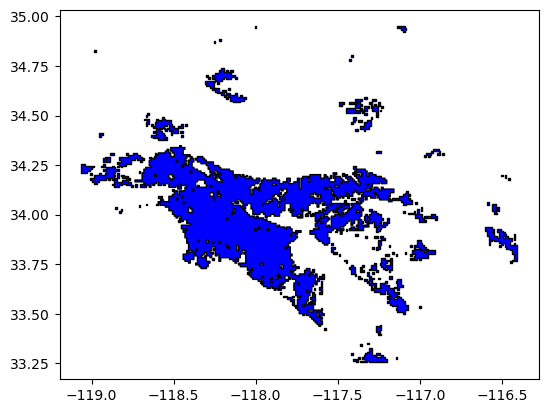

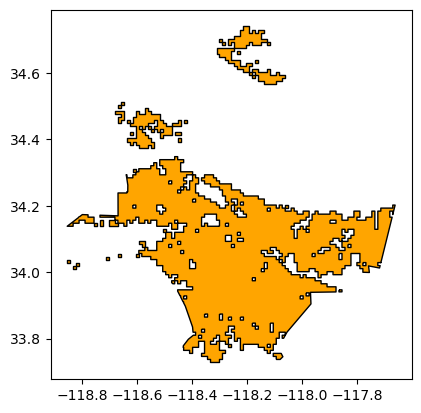

In [18]:
# -------------------------------
# 1. Prepare mask
# -------------------------------
mask = wrf_urban_mask.values.astype(np.uint8)  # 1 = urban, 0 = non-urban

# -------------------------------
# 2. Flip mask vertically for correct orientation
# -------------------------------
mask_flipped = np.flipud(mask)

# -------------------------------
# 3. Build affine transform
# -------------------------------
x2d = wrf_urban_mask['XLONG'].values
y2d = wrf_urban_mask['XLAT'].values

dx = x2d[0,1] - x2d[0,0]
dy = y2d[1,0] - y2d[0,0]

# Top-left origin for rasterio
transform = from_origin(x2d.min() - dx/2, y2d.max() + dy/2, dx, dy)

# -------------------------------
# 4. Extract polygons from mask
# -------------------------------
shapes_gen = rasterio.features.shapes(
    mask_flipped,
    mask=mask_flipped.astype(bool),
    transform=transform
)

geoms = [shape(geom) for geom, value in shapes_gen if value == 1]

# -------------------------------
# 5. Merge all polygons into one geometry
# -------------------------------
merged_geom = unary_union(geoms)

# -------------------------------
# 6. Create GeoDataFrame
# -------------------------------
gdf_urban = gpd.GeoDataFrame({'geometry': [merged_geom]}, crs="EPSG:4326")  # WGS84

# -------------------------------
# 7. Reproject LA County to match CRS
# -------------------------------
la_county_utm = la_county_boundary.to_crs(gdf_urban.crs)

# -------------------------------
# 8. Clip urban polygons to LA County
# -------------------------------
urban_la_county = gdf_urban.overlay(la_county_utm, how='intersection')

# -------------------------------
# 9. Drop empty / invalid geometries
# -------------------------------
urban_la_county = urban_la_county[
    urban_la_county.geometry.notna() & ~urban_la_county.is_empty
]

# -------------------------------
# 10. Quick plot to verify
# -------------------------------
gdf_urban.plot(facecolor='blue', edgecolor='black')
urban_la_county.plot(facecolor='orange', edgecolor='black')

<AxesSubplot: >

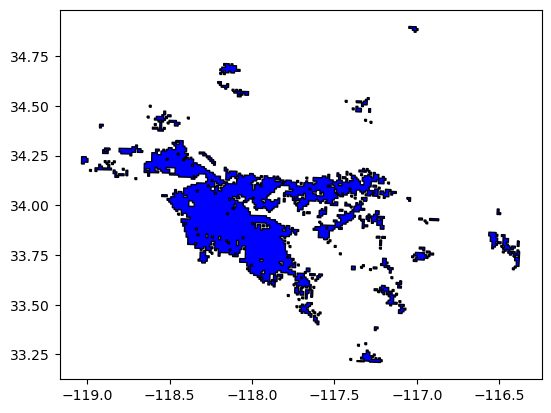

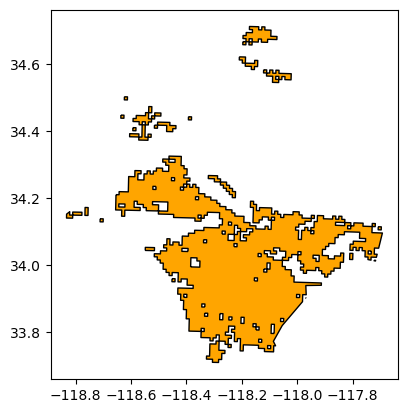

In [10]:
import numpy as np
from shapely.geometry import Polygon
from shapely.ops import unary_union
import geopandas as gpd

# 1. boolean mask
mask = (wrf_urban_mask.values == 1)

# 2. cell-center grids
x2d = wrf_urban_mask['XLONG'].values
y2d = wrf_urban_mask['XLAT'].values
nrows, ncols = x2d.shape

# 3. compute cell-corner grids by averaging neighbouring centers
#    result shape = (nrows+1, ncols+1)
x_pad = np.pad(x2d, ((1,1),(1,1)), mode='edge')
y_pad = np.pad(y2d, ((1,1),(1,1)), mode='edge')
x_c = 0.25 * (x_pad[:-1, :-1] + x_pad[1:, :-1] + x_pad[:-1, 1:] + x_pad[1:, 1:])
y_c = 0.25 * (y_pad[:-1, :-1] + y_pad[1:, :-1] + y_pad[:-1, 1:] + y_pad[1:, 1:])

# 4. build polygons for each true cell (order: top-left, top-right, bottom-right, bottom-left)
rows, cols = np.nonzero(mask)
polys = []
for r, c in zip(rows, cols):
    coords = [
        (x_c[r,   c],   y_c[r,   c]),
        (x_c[r,   c+1], y_c[r,   c+1]),
        (x_c[r+1, c+1], y_c[r+1, c+1]),
        (x_c[r+1, c],   y_c[r+1, c])
    ]
    polys.append(Polygon(coords))

# 5. merge, create GeoDataFrame, clip
merged_geom = unary_union(polys)
gdf_urban = gpd.GeoDataFrame({'geometry':[merged_geom]}, crs="EPSG:4326")
la_county_wgs = la_county_boundary.to_crs(gdf_urban.crs)
urban_la_county = gpd.overlay(gdf_urban, la_county_wgs, how='intersection')
urban_la_county = urban_la_county[urban_la_county.geometry.notna() & ~urban_la_county.is_empty]

# 6. quick plot
gdf_urban.plot(facecolor='blue', edgecolor='black')
urban_la_county.plot(facecolor='orange', edgecolor='black')

<GeoAxesSubplot: title={'center': 'WRF Urban Mask (EPSG:4326)'}>

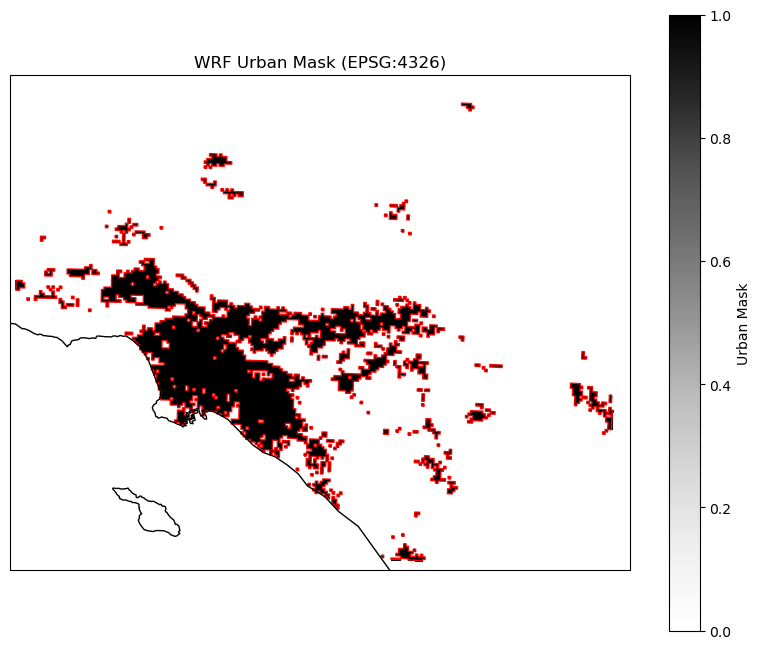

In [11]:
mask = wrf_urban_mask.values
lat = wrf_urban_mask['XLAT'].values
lon = wrf_urban_mask['XLONG'].values

fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': crs})
pcm = ax.pcolormesh(lon, lat, mask, cmap='Greys', shading='auto', transform=crs)
ax.coastlines()
ax.set_title("WRF Urban Mask (EPSG:4326)")
plt.colorbar(pcm, ax=ax, label='Urban Mask')
# Overlay gdf_urban outline in red
gdf_urban.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=1, transform=crs)

In [12]:
# save urban area in la county as geopandas compatible gpkg
save_dir = '/home1/kojoseph/ah-la-paper/data/urban_mask'
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, 'wrf_urban_mask-v4.gpkg')
urban_la_county.to_file(save_path, driver='GPKG')

In [13]:
print(la_county_boundary.crs)
print(urban_la_county.crs)

epsg:4326
EPSG:4326


<AxesSubplot: >

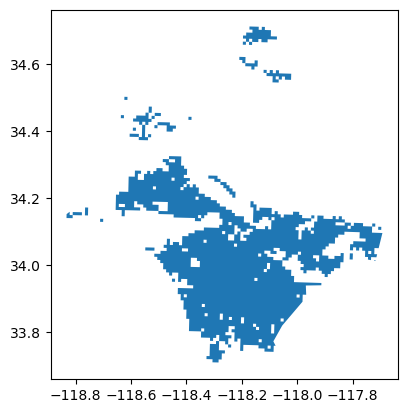

In [14]:
# reload from file to test
save_dir = '/home1/kojoseph/ah-la-paper/data/urban_mask'
save_path = os.path.join(save_dir, 'wrf_urban_mask-v4.gpkg')
test = gpd.read_file(save_path)
test.plot()

# Test clipping WRF output data

In [31]:
# test filtering wrf output files with this mask now
# import a sample wrfout file
wrf_dir = '/project2/zhan248_1326/hhao4018/WRFv4.6.1_Modified_AHoption_noChem/test/JOE_Default_08_ah=2_GDAS_frac_urb_v2'
wrf_filelist = glob.glob(os.path.join(wrf_dir, 'wrfout_d02*'))
ds = xr.open_mfdataset(wrf_filelist, 
                        engine="netcdf4",
                        concat_dim="Time",
                        combine="nested").xwrf.postprocess()
ds = ds.sortby('Time')
wrf_crs = ds.wrf_projection.item()
ds = ds.rio.write_crs(wrf_crs)
# clip wrfout with urban_la_county geometry
ds_clipped = ds.rio.clip(urban_la_county.geometry.values, urban_la_county.crs)
# plot with and without clipping
# v = 'T2'


In [22]:
ds_clipped

<xarray.Dataset>
Dimensions:                    (Time: 217, y: 111, x: 108, z: 44,
                                urban_wind_directions_stag: 4, z_stag: 45)
Coordinates:
    XTIME                      (Time) timedelta64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
  * Time                       (Time) datetime64[ns] 2016-08-10 ... 2016-08-19
    wrf_projection             int64 0
    XLAT                       (y, x) float32 dask.array<chunksize=(111, 108), meta=np.ndarray>
    XLONG                      (y, x) float32 dask.array<chunksize=(111, 108), meta=np.ndarray>
  * x                          (x) float64 1.495e+05 1.505e+05 ... 2.565e+05
  * y                          (y) float64 -3.714e+05 -3.704e+05 ... -2.614e+05
Dimensions without coordinates: z, urban_wind_directions_stag, z_stag
Data variables: (12/98)
    Times                      (Time) |S19 dask.array<chunksize=(1,), meta=np.ndarray>
    LU_INDEX                   (Time, y, x) float32 dask.array<chunksize=(1, 111, 108), meta=np.ndarray>
    Q2                         (Time, y, x) float32 dask.array<chunksize=(1, 111, 108), meta=np.ndarray>
    T2                         (Time, y, x) float32 dask.array<chunksize=(1, 111, 108), meta=np.ndarray>
    PSFC                       (Time, y, x) float32 dask.array<chunksize=(1, 111, 108), meta=np.ndarray>
    U10                        (Time, y, x) float32 dask.array<chunksize=(1, 111, 108), meta=np.ndarray>
    ...                         ...
    PC                         (Time, y, x) float32 dask.array<chunksize=(1, 111, 108), meta=np.ndarray>
    LANDMASK                   (Time, y, x) float32 dask.array<chunksize=(1, 111, 108), meta=np.ndarray>
    LAKEMASK                   (Time, y, x) float32 dask.array<chunksize=(1, 111, 108), meta=np.ndarray>
    SST                        (Time, y, x) float32 dask.array<chunksize=(1, 111, 108), meta=np.ndarray>
    SST_INPUT                  (Time, y, x) float32 dask.array<chunksize=(1, 111, 108), meta=np.ndarray>
    air_potential_temperature  (Time, z, y, x) float32 dask.array<chunksize=(1, 44, 111, 108), meta=np.ndarray>
Attributes: (12/136)
    TITLE:                            OUTPUT FROM WRF V4.6.0 MODEL
    START_DATE:                      2016-08-10_00:00:00
    SIMULATION_START_DATE:           2016-08-10_00:00:00
    WEST-EAST_GRID_DIMENSION:        245
    SOUTH-NORTH_GRID_DIMENSION:      193
    BOTTOM-TOP_GRID_DIMENSION:       45
    ...                              ...
    ISLAKE:                          21
    ISICE:                           15
    ISURBAN:                         13
    ISOILWATER:                      14
    HYBRID_OPT:                      0
    ETAC:                            0.0

In [30]:
ds['UTYPE_URB'].to_series().unique()

array([0, 8, 6, 3, 9, 2, 1, 5], dtype=int32)

In [27]:
ds['LU_INDEX'].to_series().unique()

array([17., 16.,  7., 58.,  8., 56., 53.,  9.,  6., 10.,  5., 11., 12.,
        1., 59., 52., 51., 55.], dtype=float32)

<AxesSubplot: >

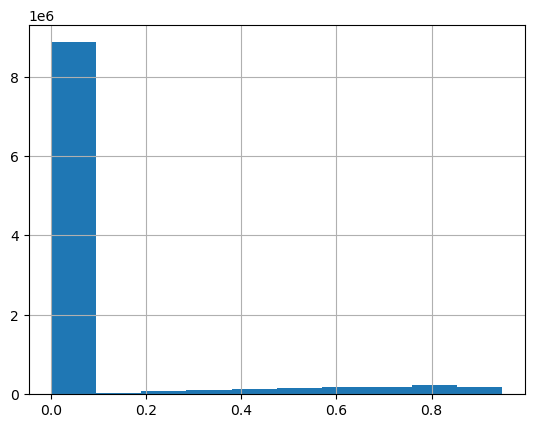

In [32]:
# distribution of urban fraction (whole domain)
ds['FRC_URB2D'].to_series().hist()

<AxesSubplot: >

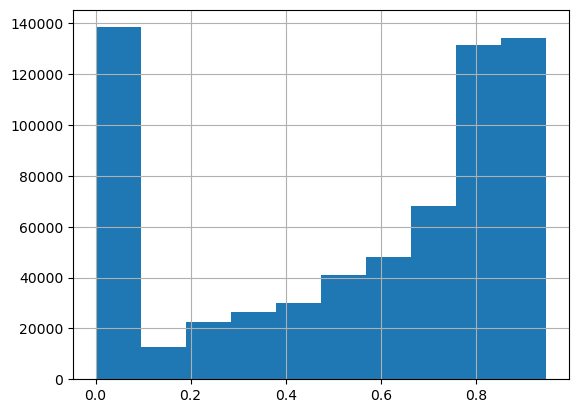

In [25]:
# distribution of urban fraction (using urban mask)
ds_clipped['FRC_URB2D'].to_series().hist()

In [33]:
num_zeros = (ds_clipped['FRC_URB2D'] == 0).sum().compute().item()
print(f"Number of zero values: {num_zeros}")

Number of zero values: 0


In [39]:
urban_la_county.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

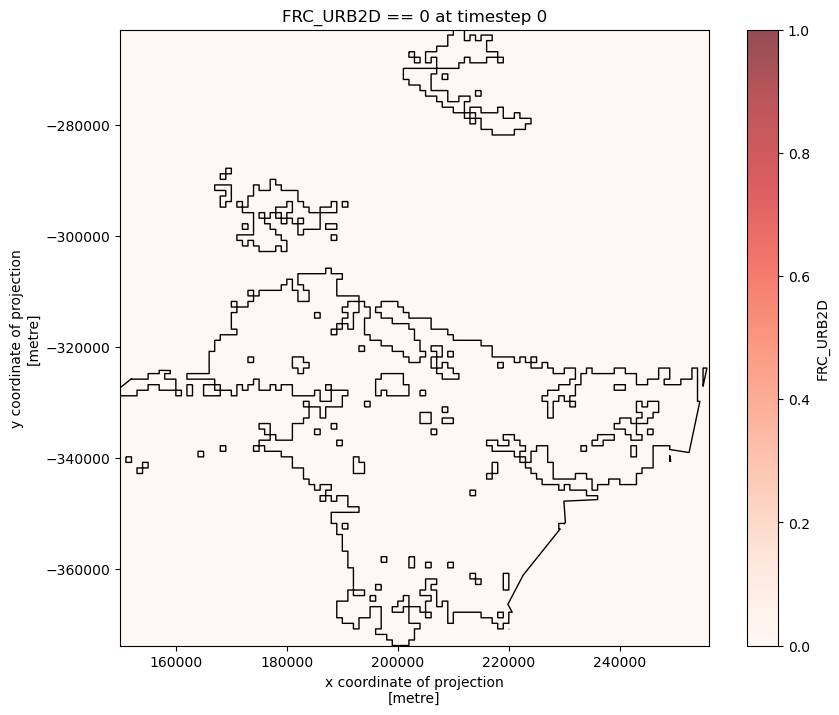

In [37]:
# Select timestep
timestep = 0
v = 'FRC_URB2D'

# Create boolean mask: True where FRC_URB2D == 0
zero_mask = ds_clipped[v].isel(Time=timestep) == 0

# Create figure
fig, ax = plt.subplots(figsize=(10, 8))

# Plot urban county boundary in the background
urban_la_county_proj = urban_la_county.to_crs(ds_clipped.rio.crs)
urban_la_county_proj.boundary.plot(ax=ax, edgecolor='black', linewidth=1)

# Plot the zero-mask on top
zero_mask.plot(ax=ax, cmap='Reds', alpha=0.7, vmin=0, vmax=1)

# Add title
ax.set_title(f"{v} == 0 at timestep {timestep}")

plt.show()

In [38]:
ds_clipped

<xarray.Dataset>
Dimensions:                    (Time: 217, y: 111, x: 106, z: 44,
                                urban_wind_directions_stag: 4, z_stag: 45)
Coordinates:
    XTIME                      (Time) timedelta64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
  * Time                       (Time) datetime64[ns] 2016-08-10 ... 2016-08-19
    wrf_projection             int64 0
    XLAT                       (y, x) float32 dask.array<chunksize=(111, 106), meta=np.ndarray>
    XLONG                      (y, x) float32 dask.array<chunksize=(111, 106), meta=np.ndarray>
  * x                          (x) float64 1.505e+05 1.515e+05 ... 2.555e+05
  * y                          (y) float64 -3.734e+05 -3.724e+05 ... -2.634e+05
Dimensions without coordinates: z, urban_wind_directions_stag, z_stag
Data variables: (12/98)
    Times                      (Time) |S19 dask.array<chunksize=(1,), meta=np.ndarray>
    LU_INDEX                   (Time, y, x) float32 dask.array<chunksize=(1, 111, 106), meta=np.ndarray>
    Q2                         (Time, y, x) float32 dask.array<chunksize=(1, 111, 106), meta=np.ndarray>
    T2                         (Time, y, x) float32 dask.array<chunksize=(1, 111, 106), meta=np.ndarray>
    PSFC                       (Time, y, x) float32 dask.array<chunksize=(1, 111, 106), meta=np.ndarray>
    U10                        (Time, y, x) float32 dask.array<chunksize=(1, 111, 106), meta=np.ndarray>
    ...                         ...
    PC                         (Time, y, x) float32 dask.array<chunksize=(1, 111, 106), meta=np.ndarray>
    LANDMASK                   (Time, y, x) float32 dask.array<chunksize=(1, 111, 106), meta=np.ndarray>
    LAKEMASK                   (Time, y, x) float32 dask.array<chunksize=(1, 111, 106), meta=np.ndarray>
    SST                        (Time, y, x) float32 dask.array<chunksize=(1, 111, 106), meta=np.ndarray>
    SST_INPUT                  (Time, y, x) float32 dask.array<chunksize=(1, 111, 106), meta=np.ndarray>
    air_potential_temperature  (Time, z, y, x) float32 dask.array<chunksize=(1, 44, 111, 106), meta=np.ndarray>
Attributes: (12/136)
    TITLE:                            OUTPUT FROM WRF V4.6.0 MODEL
    START_DATE:                      2016-08-10_00:00:00
    SIMULATION_START_DATE:           2016-08-10_00:00:00
    WEST-EAST_GRID_DIMENSION:        245
    SOUTH-NORTH_GRID_DIMENSION:      193
    BOTTOM-TOP_GRID_DIMENSION:       45
    ...                              ...
    ISLAKE:                          21
    ISICE:                           15
    ISURBAN:                         13
    ISOILWATER:                      14
    HYBRID_OPT:                      0
    ETAC:                            0.0

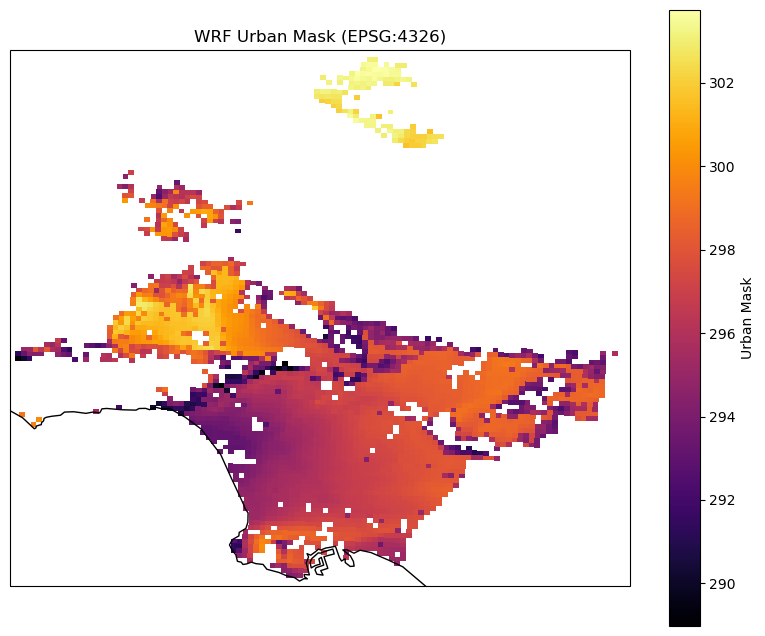

In [41]:
da = ds_clipped['T2'].isel(Time=100)
da = da.compute()
lat = ds_clipped['XLAT'].values
lon = ds_clipped['XLONG'].values
crs = ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': crs})
pcm = ax.pcolormesh(lon, lat, da, cmap='inferno', shading='auto', transform=crs)
ax.coastlines()
ax.set_title("WRF Urban Mask (EPSG:4326)")
plt.colorbar(pcm, ax=ax, label='Urban Mask')

In [26]:
(ds_clipped['FRC_URB2D']==0).sum()

<xarray.DataArray 'FRC_URB2D' ()>
dask.array<sum-aggregate, shape=(), dtype=int64, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    wrf_projection  int64 0

In [52]:
ds

<xarray.Dataset>
Dimensions:                    (Time: 217, y: 192, x: 244, z: 44,
                                urban_wind_directions_stag: 4, z_stag: 45)
Coordinates:
    XLAT                       (y, x) float32 dask.array<chunksize=(192, 244), meta=np.ndarray>
    XLONG                      (y, x) float32 dask.array<chunksize=(192, 244), meta=np.ndarray>
    XTIME                      (Time) timedelta64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
  * Time                       (Time) datetime64[ns] 2016-08-10 ... 2016-08-19
  * x                          (x) float64 1.325e+05 1.335e+05 ... 3.755e+05
  * y                          (y) float64 -4.254e+05 -4.244e+05 ... -2.344e+05
    wrf_projection             int64 0
Dimensions without coordinates: z, urban_wind_directions_stag, z_stag
Data variables: (12/98)
    Times                      (Time) |S19 dask.array<chunksize=(1,), meta=np.ndarray>
    LU_INDEX                   (Time, y, x) float32 dask.array<chunksize=(1, 192, 244), meta=np.ndarray>
    Q2                         (Time, y, x) float32 dask.array<chunksize=(1, 192, 244), meta=np.ndarray>
    T2                         (Time, y, x) float32 dask.array<chunksize=(1, 192, 244), meta=np.ndarray>
    PSFC                       (Time, y, x) float32 dask.array<chunksize=(1, 192, 244), meta=np.ndarray>
    U10                        (Time, y, x) float32 dask.array<chunksize=(1, 192, 244), meta=np.ndarray>
    ...                         ...
    PC                         (Time, y, x) float32 dask.array<chunksize=(1, 192, 244), meta=np.ndarray>
    LANDMASK                   (Time, y, x) float32 dask.array<chunksize=(1, 192, 244), meta=np.ndarray>
    LAKEMASK                   (Time, y, x) float32 dask.array<chunksize=(1, 192, 244), meta=np.ndarray>
    SST                        (Time, y, x) float32 dask.array<chunksize=(1, 192, 244), meta=np.ndarray>
    SST_INPUT                  (Time, y, x) float32 dask.array<chunksize=(1, 192, 244), meta=np.ndarray>
    air_potential_temperature  (Time, z, y, x) float32 dask.array<chunksize=(1, 44, 192, 244), meta=np.ndarray>
Attributes: (12/136)
    TITLE:                            OUTPUT FROM WRF V4.6.0 MODEL
    START_DATE:                      2016-08-10_00:00:00
    SIMULATION_START_DATE:           2016-08-10_00:00:00
    WEST-EAST_GRID_DIMENSION:        245
    SOUTH-NORTH_GRID_DIMENSION:      193
    BOTTOM-TOP_GRID_DIMENSION:       45
    ...                              ...
    ISLAKE:                          21
    ISICE:                           15
    ISURBAN:                         13
    ISOILWATER:                      14
    HYBRID_OPT:                      0
    ETAC:                            0.0

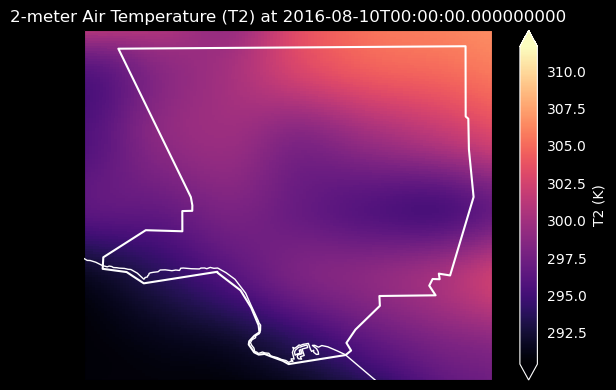

In [53]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Select time index (e.g., first timestep)
time_index = 0
t2 = ds['T2'].isel(Time=time_index)  # shape (y, x)

# Get lat/lon
lat = ds['XLAT'].values
lon = ds['XLONG'].values

# Ensure LA county geometry is in lon/lat (EPSG:4326)
la_county_wgs = la_county_gdf.to_crs(epsg=4326)

# Compute extent from LA County bounds with 5% padding
minx, miny, maxx, maxy = la_county_wgs.total_bounds
pad_frac = 0.05
dx = maxx - minx
dy = maxy - miny
extent = [minx - dx*pad_frac, maxx + dx*pad_frac,
          miny - dy*pad_frac, maxy + dy*pad_frac]

# Create figure
fig = plt.figure(figsize=(6, 4))
fig.patch.set_facecolor('black')
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax.set_facecolor('black')
ax.set_extent(extent, crs=ccrs.PlateCarree())

vmin = t2.min().compute()
vmax = t2.max().compute()
# Plot T2 as pixel grid (no interpolation)
pcm = ax.pcolormesh(
    lon, lat, t2,
    cmap='magma',
    shading='auto',  # shows raw pixels
    vmin=vmin, vmax=vmax,  # optional fixed range
    zorder=1
)

# Overlay LA County boundary
for geom in la_county_wgs.geometry:
    ax.add_geometries([geom], crs=ccrs.PlateCarree(),
                      facecolor='none', edgecolor='white', linewidth=1.5, zorder=5)

# Coastlines
ax.coastlines(color='white', zorder=4)

# Colorbar with white labels
cbar = fig.colorbar(pcm, ax=ax, extend='both')
cbar.set_label('T2 (K)', color='white')
for label in cbar.ax.get_yticklabels():
    label.set_color('white')
cbar.outline.set_edgecolor('white')

# Title
ax.set_title(f"2-meter Air Temperature (T2) at {ds['Time'].values[time_index]}", color='white')

plt.tight_layout()
plt.show()


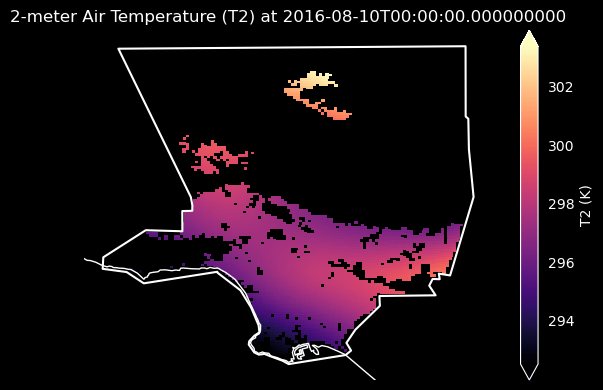

In [54]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Select time index (e.g., first timestep)
time_index = 0
t2 = ds_clipped['T2'].isel(Time=time_index)  # shape (y, x)

# Get lat/lon
lat = ds_clipped['XLAT'].values
lon = ds_clipped['XLONG'].values

# Ensure LA county geometry is in lon/lat (EPSG:4326)
la_county_wgs = la_county_gdf.to_crs(epsg=4326)

# Compute extent from LA County bounds with 5% padding
minx, miny, maxx, maxy = la_county_wgs.total_bounds
pad_frac = 0.05
dx = maxx - minx
dy = maxy - miny
extent = [minx - dx*pad_frac, maxx + dx*pad_frac,
          miny - dy*pad_frac, maxy + dy*pad_frac]

# Create figure
fig = plt.figure(figsize=(6, 4))
fig.patch.set_facecolor('black')
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax.set_facecolor('black')
ax.set_extent(extent, crs=ccrs.PlateCarree())

vmin = t2.min().compute()
vmax = t2.max().compute()
# Plot T2 as pixel grid (no interpolation)
pcm = ax.pcolormesh(
    lon, lat, t2,
    cmap='magma',
    shading='auto',  # shows raw pixels
    vmin=vmin, vmax=vmax,  # optional fixed range
    zorder=1
)

# Overlay LA County boundary
for geom in la_county_wgs.geometry:
    ax.add_geometries([geom], crs=ccrs.PlateCarree(),
                      facecolor='none', edgecolor='white', linewidth=1.5, zorder=5)

# Coastlines
ax.coastlines(color='white', zorder=4)

# Colorbar with white labels
cbar = fig.colorbar(pcm, ax=ax, extend='both')
cbar.set_label('T2 (K)', color='white')
for label in cbar.ax.get_yticklabels():
    label.set_color('white')
cbar.outline.set_edgecolor('white')

# Title
ax.set_title(f"2-meter Air Temperature (T2) at {ds_clipped['Time'].values[time_index]}", color='white')

plt.tight_layout()
plt.show()
